In [356]:
% setup environment
% clear data and number format
clear; format short e
% set path to equilibrium solver
txt=pwd; n=length(txt); rootpath=txt;
n=strfind(rootpath,"USERS"); rootpath=txt(1:n-2);
PHREEQCpath=[rootpath,'/runPHREEQC'];
addpath(PHREEQCpath);
JEQUILIBpath=[rootpath,'/JEQUILIB'];
addpath(JEQUILIBpath);
% turn off warnings
warning off
%graphics_toolkit ("notebook"); 
graphics_toolkit ("plotly"); 
%graphics_toolkit("gnuplot")
% delete phreeqcrunfile
%system("rm porttest.txt");

# model portlandite dissolution kinetics

follow the example [here](https://phreeqcusers.org/index.php?topic=1137.0) for calcite but replace with portlandite and the kinetic equation of the form 

$$\dfrac{d(portlandite)}{dt} = k_P X_P \left(\left(\dfrac{IAP_P}{Ksp_P}\right)-1\right)$$

$$ \mathrm{Ca(OH)_2}_{(\mathrm{s})} = \mathrm{Ca^{2+}} + 2\mathrm{OH^{-}}$$

$$K_{spP} = [\mathrm{Ca^{2+}}][\mathrm{OH^{-}}]^2$$

need to use llnl database because it has portlandite in it.  The mineral phase can precipitate or dissolve but starts in excess so dissolves.

# model calcite precipitation kinetics

$$\dfrac{d(calcite)}{dt} = k_C X_C \left(\left(\dfrac{IAP_C}{Ksp_C}\right)-1\right)$$

$$ \mathrm{Ca(CO_3)}_{(\mathrm{s})} = \mathrm{Ca^{2+}} + \mathrm{CO_3^{2-}}$$

$$K_{spC} = [\mathrm{Ca^{2+}}][\mathrm{CO_3^{2-}}]$$


In [357]:
database=['llnl.dat'];

# Variables 

These are the default values I wrote this script with.  The next cell you can change them.

XP=0.1 mol/L.  the initial amount of portlandite. should be a big number.

XC=1e-6 mol/L.  seed crystal amount (if zero then won't ever ppte because multiplication by zero).  1e-6 value from that paper from Australia.

kP=1e-5. just set as an arbitrary value.  need data to help figure out a reasonable value.

kC=1e-4. just set as an arbitrary value. need data to help figure out a reasonable value.  makes sense to be faster than dissolution?




In [358]:
% variables

XP=0.1; XPstr=num2str(XP);
XC=1e-6; XCstr=num2str(XC);
kP=1e-5; kPstr=num2str(kP);
kC=1e-4; kCstr=num2str(kC);
logtime=1:0.02:4; time=10.^logtime;

In [359]:
solutionboxtext=[...
{'SOLUTION 1\n'}
{'       pe      13.75\n'}
{'       pH      7\n'}
{'       temp    25\n'}
{'-units mol/kgw\n'}
   ];
[nolinesSOLN,length]=size(solutionboxtext);

In [360]:
equilibboxtext=[...
{'EQUILIBRIUM_PHASES 1\n'}
{'CO2(g)   -3.5\n'}
   ];
[nolinesEQUIL,length]=size(equilibboxtext);

In [361]:
rateboxtext=[...
{'RATES\n'}
{'Portlandite\n'}
{'-start\n'}
{'1   REM   PARM(1) = rate constant\n'}
{'10  si_pp = SI("Portlandite")\n'}
{'20  IF (M <= 0  and si_pp < 0) THEN GOTO 200\n'}
{'120 rate = PARM(1) *M* (1 - 10^(si_pp))\n'}
{'140 moles = rate*TIME\n'}
{'200 SAVE moles\n'}
{'   -end\n'}
{'Calcite\n'}
{'-start\n'}
{'1   REM   PARM(1) = rate constant\n'}
{'10  si_cc = SI("Calcite")\n'}
{'20  IF (M <= 0  and si_cc < 0) THEN GOTO 200\n'}
{'120 rate = PARM(1) *M* (1 - 10^(si_cc))\n'}
{'140 moles = rate*TIME\n'}
{'200 SAVE moles\n'}
{'   -end\n'}
];
[nolinesRATE,length]=size(rateboxtext);

In [362]:
m0Pline=['  -m0    ',XPstr,'\n'];
mPline=['  -m    ',XPstr,'\n'];
parmsPline=['  -parms ',kPstr,'\n'];
m0Cline=['  -m0    ',XCstr,'\n'];
mCline=['  -m    ',XCstr,'\n'];
parmsCline=['  -parms ',kCstr,'\n'];
timestr=mat2str([0 time]); timestr = regexprep(timestr,'\[','');  timestr = regexprep(timestr,'\]','');
timeline=[' -steps ',timestr,' s\n'];

kineticsboxtext=[...
{'KINETICS 1\n'}
{'Portlandite\n'}
{'  -tol   1e-8\n'}
{m0Pline}
{mPline}
{parmsPline}
{'Calcite\n'}
{'  -tol   1e-8\n'}
{m0Cline}
{mCline}
{parmsCline}
{timeline}
%{'  -steps 0 10 20 30 40 50 60 70 80 90 100 120 140 160 300 500 1000 1500 2000 3000 4000 5000 s\n'}
%{'  -steps 10000 in 25 steps\n'}
{'  -cvode\n'}
];
[nolinesKIN,length]=size(kineticsboxtext);

In [363]:
selectboxtext=[...
{' SELECTED_OUTPUT\n'}
{' -file portout.txt\n'}
{' -selected_out true\n'}
{' -user_punch true\n'}
{' -high_precision true\n'}
{' -reset false\n'}
{' -simulation false\n'}
{' -state false\n'}
{' -distance false\n'}
{' -time false\n'}
{' -step false\n'}
{' -ph false\n'}
{' -pe false\n'}
{' -reaction false\n'}
{' -temperature false\n'}
{' -alkalinity false\n'}
{' -ionic_strength false\n'}
{' -water false\n'}
{' -charge_balance false\n'}
{' -percent_error false\n'}
%{' -molalities H+ Ca+2  \n'}
%{' -equilibrium_phases CO2(g)  \n'}
];
[nolinesSEL,length]=size(selectboxtext);

In [364]:
punchboxtext=[...
{'USER_PUNCH\n'}
{'        -headings seconds  Ca  pH Calcite  Portlandite \n'}
{'  10 PUNCH SIM_TIME, TOT("Ca"), -LA("H+"), KIN("Calcite"), KIN("Portlandite") \n'}
];
[nolinesPUNCH,length]=size(punchboxtext);

In [365]:
fileID=fopen('porttest.txt','w');

fprintf(fileID,'TITLE TEST PORTLANDITE DISSOLUTION\n');

for i=1:nolinesSOLN
    line=cell2mat(solutionboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
for i=1:nolinesEQUIL
    line=cell2mat(equilibboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
for i=1:nolinesRATE
    line=cell2mat(rateboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
for i=1:nolinesKIN
    line=cell2mat(kineticsboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
for i=1:nolinesSEL
    line=cell2mat(selectboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
for i=1:nolinesPUNCH
    line=cell2mat(punchboxtext(i,:));
    fprintf(fileID,line)
end
fprintf(fileID,'\n');
fprintf(fileID,'END');
fclose(fileID);

In [366]:
str=['system("phreeqc porttest.txt out.txt ', database,'");'];
eval(str); % output to the screen
%evalc(str); % so no screen output
fid = fopen('portout.txt','rt');
hdr = strtrim(regexp(fgetl(fid),'\t','split'));
hdr=hdr(1:5)';
mat = cell2mat(textscan(fid,repmat('%f',1,numel(hdr))));
[nsize,msize]=size(mat);
time=mat(2:nsize,1); Caphreeqc=mat(2:nsize,2); pHphreeqc=mat(2:nsize,3);
calcitephreeqc=mat(2:nsize,4); portlanditephreeqc=mat(2:nsize,5);

# also solve with the ODE solver

In [367]:
function [H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(Ca,Kw,KH,Ka1,Ka2,PCO2)

a=1; b=2*Ca; c=-KH*Ka1*PCO2-Kw; d=-2*KH*Ka1*Ka2*PCO2;
H=roots([a b c d]);
H=H(imag(H)==0); %sets any imaginary roots to zero
% display the positive real root
H=H(H>0);
%solve speciation
H2CO3=KH*PCO2; HCO3=(KH*PCO2*Ka1)/H; CO3=(KH*PCO2*Ka1*Ka2)/(H^2); OH=Kw/H;

end

In [368]:
% try with ode solver.  first need to define the function

function dCdt=dC_by_dt(t,C,Kw,KH,Ka1,Ka2,PCO2,KspC,KspP,kC,kP)

[H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(C(3),Kw,KH,Ka1,Ka2,PCO2);

IAPP=C(3)*OH^2; IAPC=C(3)*CO3;

dCdt=zeros(3,1); % top entry is [portlandite].  bottom entry is [calcium cation].  middle is calcite conc

% the three entries for the 3 rates. 

%rate of decrease in portlandite concentration.  IAP/Ksp is less than 1 so rate is negative
dCdt(1)=kP*C(1)*(IAPP/KspP-1);  

%rate of formation of calcite
if IAPC/KspC >1; dCdt(2)=C(2)*kC*(((IAPC/KspC-1))); end

%rate of increase in calcium concentration from port dissolve and decrease Ca from calcite ppte
dCdt(3)=-kP*C(1)*(IAPP/KspP-1)-C(2)*kC*(IAPC/KspC-1);  

dC=dCdt;


end

In [369]:
% make an anonymous function because ODE solver only wants conc and time as variables
% and dfine all the constants too

%Kw=1e-14; KH=10^-1.47; Ka1=10^-6.3; Ka2=10^-10.3; PCO2=10^-3.5; KspC=3.4e-9; KspC=1.4e-8;
%KspP=5.5e-6; kC=1e-4; kP=1e-6;

Kw=1e-14; KH=10^-1.47; Ka1=10^-6.3; Ka2=10^-10.3; PCO2=10^-3.5; KspC=3.4e-9; %KspC=1.4e-8;
KspP=5.5e-6; KspP=3.5645e-6;
kC=1e-4; kP=1e-5;

dCdtrate = @(t,C)dC_by_dt(t,C,Kw,KH,Ka1,Ka2,PCO2,KspC,KspP,kC,kP);

%[value]=dCdtrate(0,[0.2 1e-9 1e-1]);


 = red phreeqc blue ODE


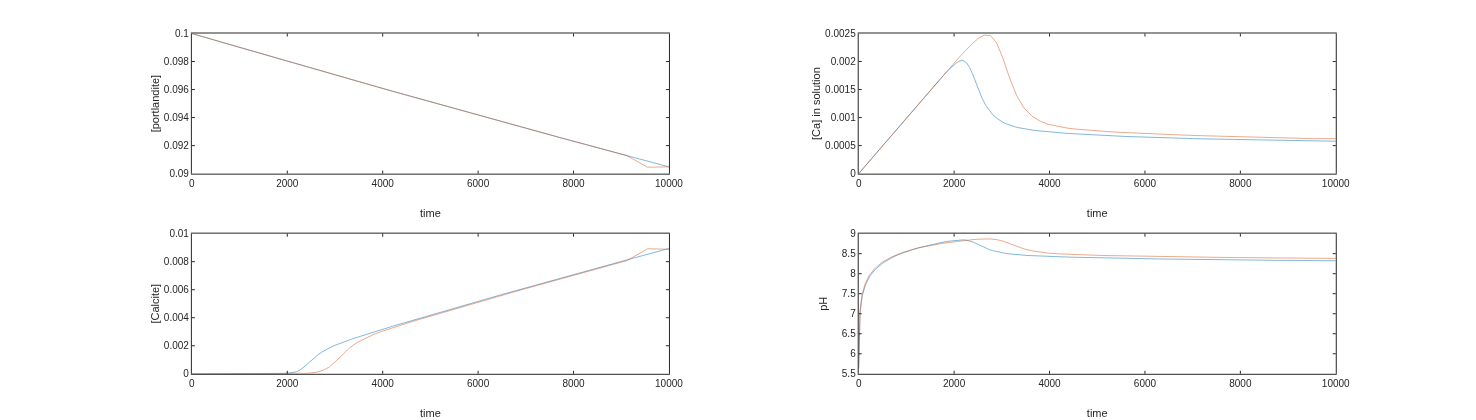

In [370]:
display('red phreeqc blue ODE')

% call ODE solver

[t, C]=ode45(dCdtrate,[0 10000],[0.1 1e-6 0]);

port=C(:,1); %portlandite left over
calcite=C(:,2); %Calcite formed
Ca=C(:,3); %Ca
pH=[]; % pH reset

for i=1:size(Ca,1)
    [H,OH,H2CO3,HCO3,CO3]=CCaspeciesopen(Ca(i),Kw,KH,Ka1,Ka2,PCO2);
    pH(i)=-log10(H);
end

subplot(221); plot(t,port,time,portlanditephreeqc); ylabel('[portlandite]'); xlabel('time')
subplot(222); plot(t,Ca,time,Caphreeqc); ylabel('[Ca] in solution'); xlabel('time')
subplot(223); plot(t,calcite,time,calcitephreeqc); ylabel('[Calcite]'); xlabel('time')
subplot(224); plot(t,pH,time,pHphreeqc); ylabel('pH'); xlabel('time')

